### Biblioteki

In [113]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

### Plan działania

1. Podział danych. Stworzyć zbiory dancyh odpowiednie pod :
    - zbiór dancyh z klasami zamiast ceny oraz kodowaniem ONE-HOT-ENCODING
    - zbiór danych z normalną ceną oraz kodowaniem ONE-HOT-ENCODING
    - zbiory danych jak powyżej ale BEZ kodowania ONE-HOT-ENCODING żeby przetestować Embeddingi
2. Przeprowadzić badania dla podanych poniżej modeli
    - model klasyfikacji
    - model regresji
    Przetestować następujące czynniki:
    - Które kodowanie daje lepsze rezultaty OHE, Embeddingi czy brak
    - Jak na wynik wpływa skalowanie danych
    - Różne architektury sieci
    - Różne hipermarametry : learning_rate, weigt_decay...
3. Wybrać najlepszy model i wykonać na nim predykcje 

# 1. Tworzenie zbiorów danych

### Wczytanie danych

In [3]:
evaluation_dataset = pd.read_csv('test_data.csv')
train_data = pd.read_csv('train_data.csv')

### Wgląd w dostępne dane

In [4]:
train_data.head(20)

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
5,61946,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
6,84070,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
7,83185,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
8,168141,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0
9,153982,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0


## 1.1 Tworzenie zbioru dla klasyfikatora z wykorzystaniem One-Hot-Encoding

Jak widać, dostępne dane są zarówno numeryczne i jak tekstowe (kategoryczne). Żeby nasz model pracował jak najlepiej, wypadałoby wprowadzić kilka zmian, żeby móc korzystać z większej ilości danych w trakcie treningu modelu. Oto propozycje zmian :
1. Przyporządkować  kwoty z kolumny **"SalePrice"** do jedenj z trzech kategorii : 
    - cheap < 100_000
    - average <250_000
    - expensive > 250_000
2. Zamienić dane z kolumny **"TimeToBusStop"** oraz z kolumny **"TimeToSubway""** na średnią wartość potrzebnego czasu tj. : 15min~20min zamienić na 17.5 (jako czas w minutach) 
3. Zmeinić dane z kolumn **"HallwayType"**, **"HeatingType"**, **"AptManageType"** oraz **"SubwayStation"** na kodowanie ONE-HOT-ENCODING

Po takim przygotowaniu danych, zwiększymy ich zaawansowanie, dzięki czemu nasz model będzie w stanie dostrajać się na większej ilości danych

### Ustawienie klasy apartamentu

In [5]:
def map_data(df: pd.DataFrame) -> pd.DataFrame:
    df['label'] = df['SalePrice'].apply(lambda x: 'cheap' if x <= 100_000 else 'average' if x <= 250_000 else 'expensive')
    return df

reworked_train_data = train_data.copy()
reworked_train_data = map_data(reworked_train_data)
reworked_train_data.head(20)


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),label
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,average
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,expensive
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
5,61946,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
6,84070,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
7,83185,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
8,168141,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average
9,153982,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average


In [6]:
# pozbycie się kolumn, z ceną mieszkania
reworked_train_data.drop(columns=['SalePrice'], inplace=True)
reworked_train_data.head(20)

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,average
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,expensive
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
5,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
6,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
7,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
8,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average
9,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average


### Wgląd w rozkład klasowy

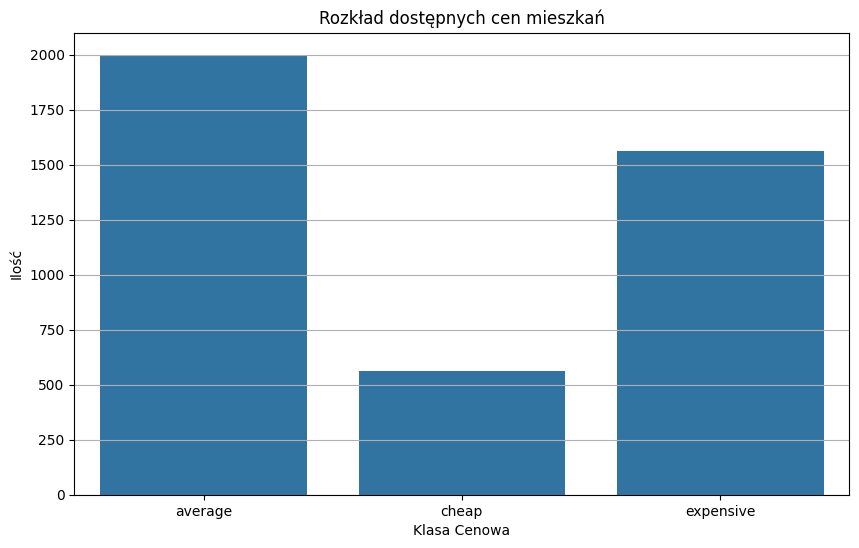

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=reworked_train_data, x='label')
plt.title('Rozkład dostępnych cen mieszkań')
plt.xlabel('Klasa Cenowa')
plt.ylabel('Ilość')
plt.grid(axis='y')
plt.show()

Widać, że najwięcej mieszkań znajduje się w klasie cenowej **"average"**, a mieszkań w klasie cenowej **"cheap"** jest najmniej. Będzie trzeba do dobrze uwzględnić wdzieląc nasze dane na treningowe, testowe i walidacyjne

### Zmiana **"HallwayType"**, **"HeatingType"**, **"AptManageType"** oraz **"SubwayStation"** na kodowanie ONE-HOT-ENCODING

In [8]:
print(f"HallwayType : {pd.unique(reworked_train_data['HallwayType'])}")
print(f"HeatingType : {pd.unique(reworked_train_data['HeatingType'])}")
print(f"AptManageType : {pd.unique(reworked_train_data['AptManageType'])}")
print(f"SubwayStation : {pd.unique(reworked_train_data['SubwayStation'])}")

HallwayType : ['terraced' 'corridor' 'mixed']
HeatingType : ['individual_heating' 'central_heating']
AptManageType : ['management_in_trust' 'self_management']
SubwayStation : ['Kyungbuk_uni_hospital' 'Daegu' 'Sin-nam' 'Myung-duk' 'Chil-sung-market'
 'Bangoge' 'Banwoldang' 'no_subway_nearby']


In [9]:
reworked_train_data_dummies = pd.get_dummies(reworked_train_data, columns=['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation'])
reworked_train_data_dummies.columns

Index(['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'TimeToBusStop', 'TimeToSubway', 'N_manager',
       'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)',
       'N_SchoolNearBy(Total)', 'label', 'HallwayType_corridor',
       'HallwayType_mixed', 'HallwayType_terraced',
       'HeatingType_central_heating', 'HeatingType_individual_heating',
       'AptManageType_management_in_trust', 'AptManageType_self_management',
       'SubwayStation_Bangoge', 'SubwayStation_Banwoldang',
       'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu',
       'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk',
       'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby'],
      dtype='object')

In [10]:
reworked_train_data_dummies[['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced', 'HeatingType_central_heating', 'HeatingType_individual_heating', 'AptManageType_management_in_trust', 'AptManageType_self_management', 'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk', 'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']] = reworked_train_data_dummies[['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced', 'HeatingType_central_heating', 'HeatingType_individual_heating', 'AptManageType_management_in_trust', 'AptManageType_self_management', 'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk', 'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']].astype(int)
reworked_train_data_dummies.head(20)

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,5min~10min,10min~15min,3.0,0.0,5,...,1,0,0,0,0,0,1,0,0,0
1,1985,587,8,80.0,76.0,0~5min,5min~10min,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
2,1985,587,6,80.0,76.0,0~5min,5min~10min,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
3,2006,2056,8,249.0,536.0,0~5min,0-5min,5.0,11.0,5,...,1,0,0,0,0,0,0,0,1,0
4,1992,644,2,142.0,79.0,5min~10min,15min~20min,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
5,1993,644,10,523.0,536.0,0~5min,15min~20min,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
6,1993,644,3,523.0,536.0,0~5min,15min~20min,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
7,1992,644,13,142.0,79.0,5min~10min,15min~20min,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
8,1986,1377,4,713.0,0.0,0~5min,10min~15min,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0
9,1986,914,11,713.0,0.0,0~5min,10min~15min,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0


### Zmiana kolumn **TimeToBusStop** oraz **TimeToSubway** na wartości numeryczne

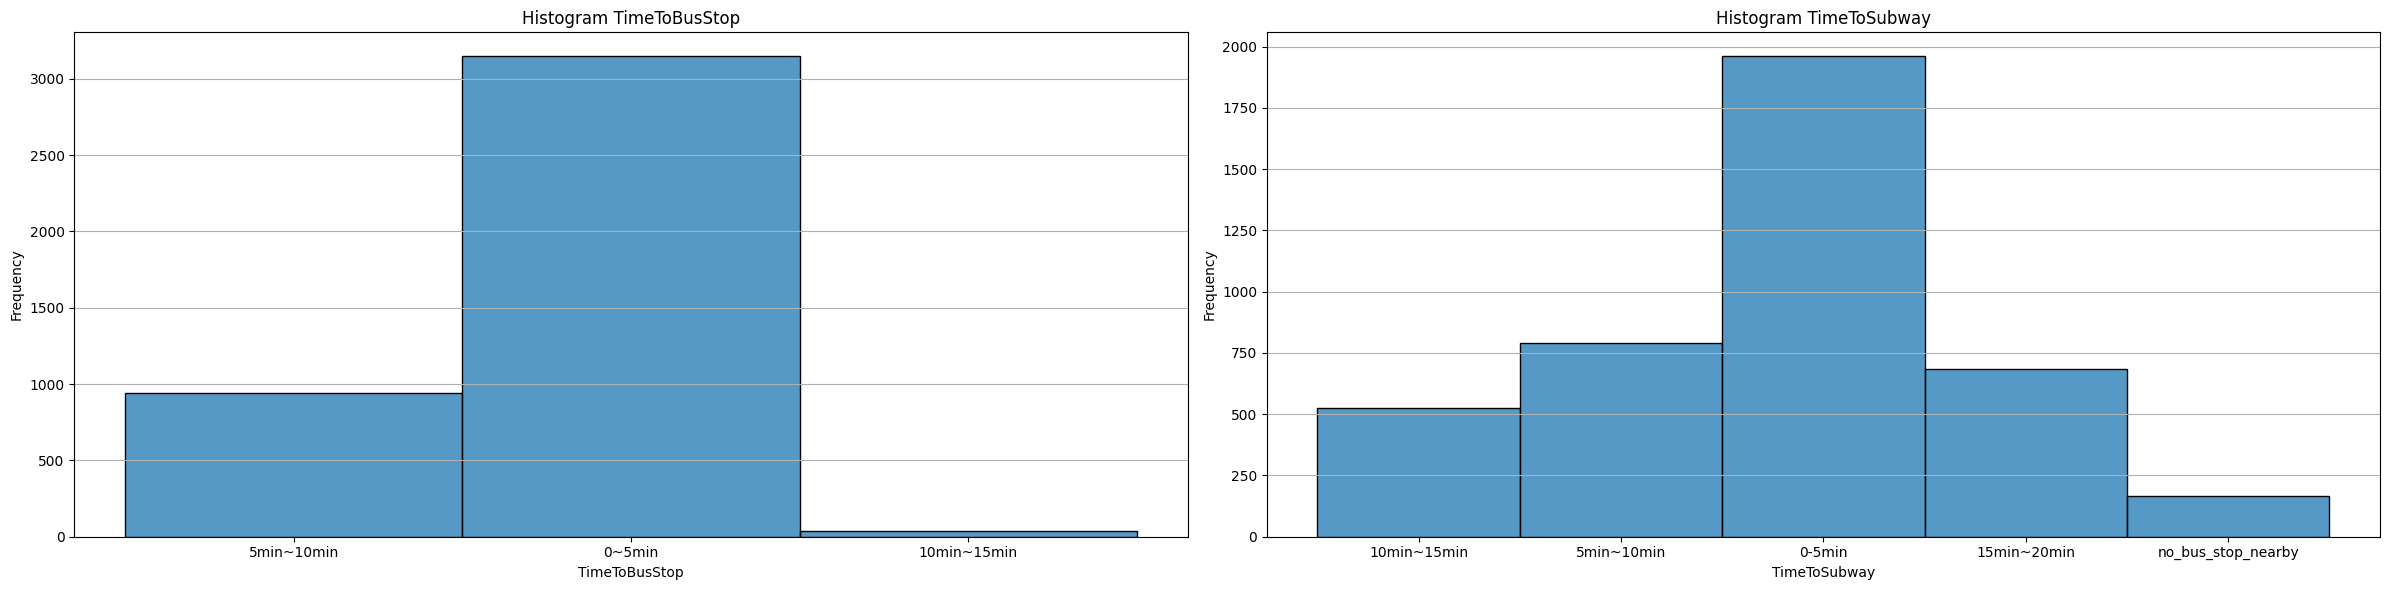

In [11]:
plt.figure(figsize=(24, 6))

# Histogram for TimeToBusStop
plt.subplot(1, 2, 1)
sns.histplot(data=reworked_train_data_dummies, x='TimeToBusStop')
plt.title('Histogram TimeToBusStop')
plt.xlabel('TimeToBusStop')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Histogram for TimeToSubway
plt.subplot(1, 2, 2)
sns.histplot(data=reworked_train_data_dummies, x='TimeToSubway')
plt.title('Histogram TimeToSubway')
plt.xlabel('TimeToSubway')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [12]:
# jak nie ma blisko metra to daję największą wartość jako "karę" za daleki dystans do metra
def map_times(df: pd.DataFrame, no_subway_cost) -> pd.DataFrame:
    df['TimeToBusStop'] = df['TimeToBusStop'].apply(lambda x: 2.5 if x == "0~5min" else 7.5 if x == "5min~10min" else 12.5)
    df['TimeToSubway'] = df['TimeToSubway'].apply(lambda x: 2.5 if x == "0~5min" else 7.5 if x == "5min~10min" else 12.5 if x == "10min~15min" else 17.5 if x == "15min~20min" else no_subway_cost)
    return df

fully_reworked_train_data = reworked_train_data_dummies.copy()
fully_reworked_train_data = map_times(fully_reworked_train_data, 60)

### Ostateczny wygląd danych

In [38]:
fully_reworked_train_data['label']

0         average
1           cheap
2           cheap
3       expensive
4           cheap
          ...    
4119    expensive
4120    expensive
4121    expensive
4122    expensive
4123    expensive
Name: label, Length: 4124, dtype: object

In [13]:
fully_reworked_train_data.head(20)

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,7.5,12.5,3.0,0.0,5,...,1,0,0,0,0,0,1,0,0,0
1,1985,587,8,80.0,76.0,2.5,7.5,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
2,1985,587,6,80.0,76.0,2.5,7.5,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
3,2006,2056,8,249.0,536.0,2.5,60.0,5.0,11.0,5,...,1,0,0,0,0,0,0,0,1,0
4,1992,644,2,142.0,79.0,7.5,17.5,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
5,1993,644,10,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
6,1993,644,3,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
7,1992,644,13,142.0,79.0,7.5,17.5,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
8,1986,1377,4,713.0,0.0,2.5,12.5,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0
9,1986,914,11,713.0,0.0,2.5,12.5,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0


## 1.2 Zbiór danych dla klasyfikatora BEZ kodowania ONE-HOT-ENCODING

In [14]:
classyficator_without_ohe = train_data.copy()
classyficator_without_ohe = map_data(classyficator_without_ohe)
classyficator_without_ohe.drop(columns=['SalePrice'], inplace=True)

classyficator_without_ohe = map_times(classyficator_without_ohe, 60)
classyficator_without_ohe.head(20)

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,7.5,12.5,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,average
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,2.5,7.5,2.0,2.0,Daegu,3,12.0,4.0,cheap
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,2.5,7.5,2.0,2.0,Daegu,3,12.0,4.0,cheap
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,2.5,60.0,5.0,11.0,Sin-nam,5,3.0,7.0,expensive
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,7.5,17.5,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
5,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,2.5,17.5,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
6,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,2.5,17.5,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
7,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,7.5,17.5,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
8,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,2.5,12.5,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average
9,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,2.5,12.5,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average


## 1.3 Zbiór do zadania regresji z kodowaniem ONE-HOT-ENCODING

In [23]:
linear_regression_data_ohe = train_data.copy()
linear_regression_data_ohe = map_times(linear_regression_data_ohe, 60)
linear_regression_data_ohe = pd.get_dummies(linear_regression_data_ohe, columns=['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation'])
# cast boolen to int
linear_regression_data_ohe[['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced', 'HeatingType_central_heating', 'HeatingType_individual_heating', 'AptManageType_management_in_trust', 'AptManageType_self_management', 'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk', 'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']] = reworked_train_data_dummies[['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced', 'HeatingType_central_heating', 'HeatingType_individual_heating', 'AptManageType_management_in_trust', 'AptManageType_self_management', 'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk', 'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']].astype(int)
linear_regression_data_ohe.head(20)

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,814,3,111.0,184.0,7.5,12.5,3.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,51327,1985,587,8,80.0,76.0,2.5,7.5,2.0,2.0,...,0,1,0,0,0,1,0,0,0,0
2,48672,1985,587,6,80.0,76.0,2.5,7.5,2.0,2.0,...,0,1,0,0,0,1,0,0,0,0
3,380530,2006,2056,8,249.0,536.0,2.5,60.0,5.0,11.0,...,1,0,0,0,0,0,0,0,1,0
4,78318,1992,644,2,142.0,79.0,7.5,17.5,4.0,8.0,...,0,1,0,0,0,0,0,1,0,0
5,61946,1993,644,10,523.0,536.0,2.5,17.5,8.0,20.0,...,1,0,0,0,0,0,0,1,0,0
6,84070,1993,644,3,523.0,536.0,2.5,17.5,8.0,20.0,...,1,0,0,0,0,0,0,1,0,0
7,83185,1992,644,13,142.0,79.0,7.5,17.5,4.0,8.0,...,0,1,0,0,0,0,0,1,0,0
8,168141,1986,1377,4,713.0,0.0,2.5,12.5,8.0,27.0,...,1,0,0,0,0,0,1,0,0,0
9,153982,1986,914,11,713.0,0.0,2.5,12.5,8.0,27.0,...,1,0,0,0,0,0,1,0,0,0


## 1.4 Zbiór do zadania regresji BEZ kodowanie OHE

In [24]:
linear_regression_data_wihtout_ohe = train_data.copy()
linear_regression_data_ohe_without_ohe = map_times(linear_regression_data_wihtout_ohe, 60)
linear_regression_data_wihtout_ohe.head(20)

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,7.5,12.5,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,2.5,7.5,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,2.5,7.5,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,2.5,60.0,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,7.5,17.5,4.0,8.0,Myung-duk,3,9.0,14.0
5,61946,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,2.5,17.5,8.0,20.0,Myung-duk,4,14.0,17.0
6,84070,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,2.5,17.5,8.0,20.0,Myung-duk,4,14.0,17.0
7,83185,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,7.5,17.5,4.0,8.0,Myung-duk,3,9.0,14.0
8,168141,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,2.5,12.5,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0
9,153982,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,2.5,12.5,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0


# Odpowiedni podział danych na zbiór treningowy i testowy
- zbiór treningowy będzie służył do nauki modelu
- zbiór testowy będzie służył do sprawdzania dokładności modelu

In [30]:
TEST_SIZE = 0.2

x_train, x_test, y_train, y_test = train_test_split(fully_reworked_train_data.drop(columns=['label']), fully_reworked_train_data['label'], test_size=TEST_SIZE, random_state=42)

### Podział klas w zbiorach

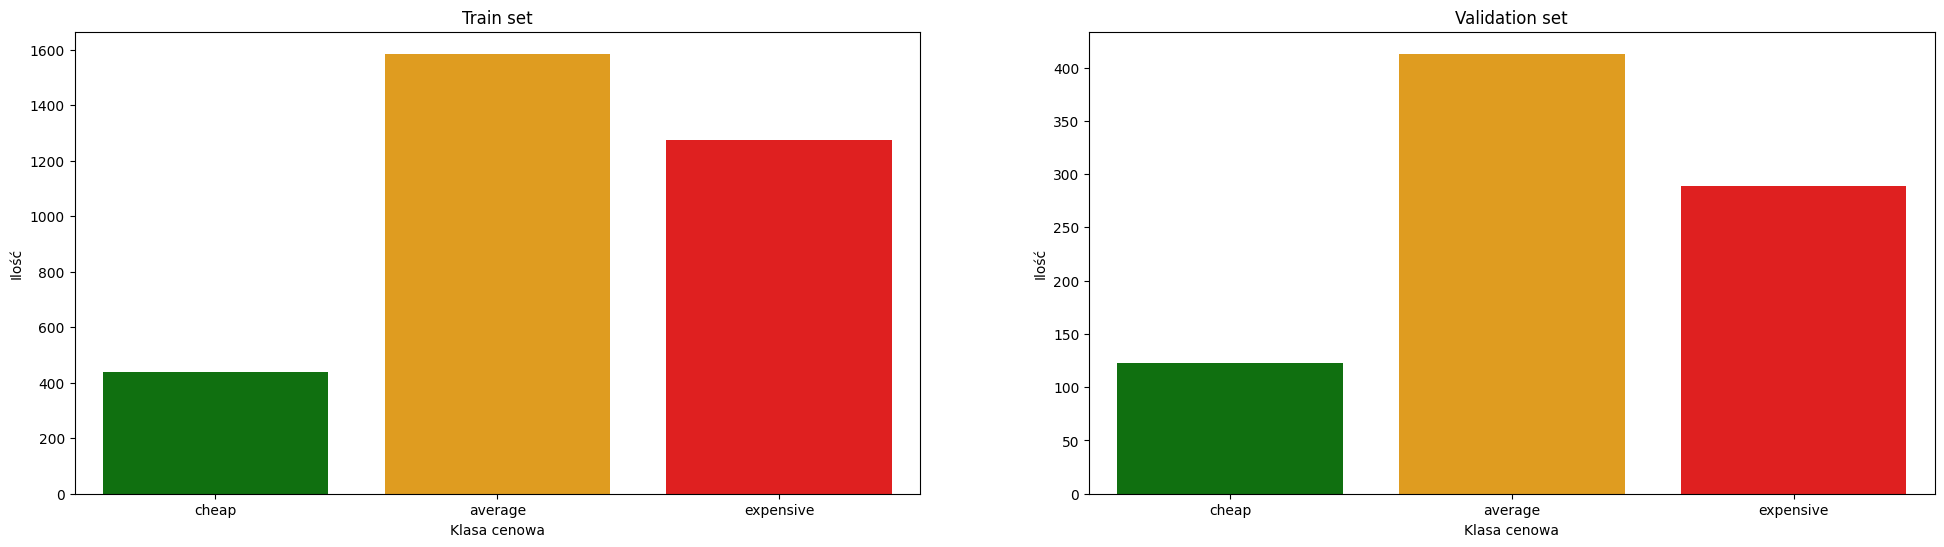

In [31]:
palette = {'cheap': 'green', 'average': 'orange', 'expensive': 'red'}

plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=pd.DataFrame(y_train, columns=['label']), x='label', hue='label', order=['cheap', 'average', 'expensive'], palette=palette, legend=False)
plt.title('Train set')
plt.xlabel('Klasa cenowa')
plt.ylabel('Ilość')

plt.subplot(1, 2, 2)
sns.countplot(data=pd.DataFrame(y_test, columns=['label']), x='label', hue='label', order=['cheap', 'average', 'expensive'], palette=palette, legend=False)
plt.title('Validation set')
plt.xlabel('Klasa cenowa')
plt.ylabel('Ilość')

plt.show()

In [32]:
print(f"Train set")
display(x_train.head(5))
print(f"Test set")
display(x_test.head(5))

Train set


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
3162,1993,914,9,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
2514,2007,868,24,0.0,1270.0,2.5,60.0,14.0,16.0,10,...,1,0,0,0,0,0,1,0,0,0
1894,2006,1149,18,249.0,536.0,2.5,60.0,5.0,11.0,5,...,1,0,0,0,0,0,0,0,1,0
3612,2005,914,12,67.0,798.0,2.5,7.5,6.0,0.0,7,...,1,0,1,0,0,0,0,0,0,0
3349,2013,644,3,8.0,930.0,2.5,60.0,6.0,14.0,7,...,1,0,0,0,0,0,1,0,0,0


Test set


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
1104,2007,1690,3,7.0,605.0,2.5,60.0,5.0,5.0,5,...,1,0,0,1,0,0,0,0,0,0
1766,2006,903,9,123.0,181.0,7.5,60.0,3.0,11.0,4,...,1,0,0,0,0,0,0,1,0,0
4011,2014,910,21,90.0,1174.0,2.5,60.0,7.0,20.0,9,...,1,0,0,0,0,0,0,1,0,0
3972,2013,910,4,8.0,930.0,2.5,60.0,6.0,14.0,7,...,1,0,0,0,0,0,1,0,0,0
2759,2007,1643,19,0.0,1270.0,2.5,60.0,14.0,16.0,10,...,1,0,0,0,0,0,1,0,0,0


# 2. Przeprowadzanie badań

## Funkcje pomocnicze

In [130]:
def scale_data(train: pd.DataFrame, test: pd.DataFrame) -> tuple:
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled

def prepare_data_into_minibatches(x_train, y_train, x_test, y_test, batch_size: int) -> tuple:
    # convert to numpy arrays
    if isinstance(x_train, pd.DataFrame):
        x_train = x_train.values
    if isinstance(x_test, pd.DataFrame):
        x_test = x_test.values

    #create tensot datasets
    train_dataset = TensorDataset(
        torch.tensor(x_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    test_dataset = TensorDataset(
        torch.tensor(x_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )

    # create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def train_classificator_without_minibatches(model, optimizer, criterion, epochs, x_train, y_train, x_test, y_test, verbose=True):

    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)

        loss = criterion(output, y_train)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        train_acc = (output.argmax(dim=1) == y_train).float().mean()
        train_accuracy.append(train_acc)

        with torch.no_grad():
            model.eval()
            output = model(x_test)
            loss = criterion(output, y_test)
            test_loss.append(loss.item())

            test_acc = (output.argmax(dim=1) == y_test).float().mean()
            test_accuracy.append(test_acc)
            model.train()

        if verbose and epoch % 20 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss[-1]:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss[-1]:.4f} | Test acc: {test_acc:.4f}")

    return train_accuracy, test_accuracy, train_loss, test_loss

def train_classificator_with_minibatches(model, optimizer, criterion, epochs, train_loader, test_loader, verbose=True):
    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train_samples = 0

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)

            loss = criterion(output, y_batch)
            total_train_loss += loss.item() * x_batch.size(0)  # weighted by batch size
            correct_train += (output.argmax(dim=1) == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / total_train_samples
        avg_train_acc = correct_train / total_train_samples
        train_loss.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)

        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test_samples = 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                output = model(x_batch)
                loss = criterion(output, y_batch)
                total_test_loss += loss.item() * x_batch.size(0)
                correct_test += (output.argmax(dim=1) == y_batch).sum().item()
                total_test_samples += y_batch.size(0)

        avg_test_loss = total_test_loss / total_test_samples
        avg_test_acc = correct_test / total_test_samples
        test_loss.append(avg_test_loss)
        test_accuracy.append(avg_test_acc)

        if verbose and epoch % 20 == 0:
            print(f"Epoch: {epoch} | Train loss: {avg_train_loss:.4f} | Train acc: {avg_train_acc:.4f} | Test loss: {avg_test_loss:.4f} | Test acc: {avg_test_acc:.4f}")

    return train_accuracy, test_accuracy, train_loss, test_loss


def plot_metrics(train_accuracy, test_accuracy, train_loss, test_loss, title):
    plt.figure(figsize=(24, 6))

    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train loss')
    plt.plot(test_loss, label='Test loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()


## 2.1 Czysty klafyfikator

### Model z 3 warstwami

In [96]:
class HousePriceClassificator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


#### OHE : preparing data

In [137]:
def run_experiment(
    title: str,
    model_class,
    x_train=None,
    y_train=None,
    x_test=None,
    y_test=None,
    train_loader=None,
    test_loader=None,
    use_minibatch=True,
    input_size=None,
    weight_decay=0,
    hidden_size=256,
    output_size=3,
    dropout=0.2,
    lr=0.001,
    epochs=100,
    seed=42,
    verbose=True,
    is_plot=True
):
    # set deterministic seed
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"\n--- Running: {title} ---")

    model = model_class(input_size, hidden_size, output_size, dropout)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    if use_minibatch:
        train_accuracy, test_accuracy, train_loss, test_loss = train_classificator_with_minibatches(
            model, optimizer, criterion, epochs, train_loader, test_loader, verbose
        )
    else:
        train_accuracy, test_accuracy, train_loss, test_loss = train_classificator_without_minibatches(
            model, optimizer, criterion, epochs, x_train, y_train, x_test, y_test, verbose
        )

    if is_plot:
        plot_metrics(train_accuracy, test_accuracy, train_loss, test_loss, title)

    print(f"Train accuracy: {train_accuracy[-1]:.4f} | Test accuracy: {test_accuracy[-1]:.4f}")
    print(f"Train loss: {train_loss[-1]:.4f} | Test loss: {test_loss[-1]:.4f}")

    return train_accuracy, test_accuracy, train_loss, test_loss

In [119]:
TEST_SIZE = 0.2
# encoder
label_encoder = LabelEncoder()

# raw data
x_train, x_test, y_train, y_test = train_test_split(fully_reworked_train_data.drop(columns=['label']), fully_reworked_train_data['label'], test_size=TEST_SIZE, random_state=42)

y_test = label_encoder.fit_transform(y_test)
y_train = label_encoder.transform(y_train)

# change to tensor
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# scaled data
x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

x_train_scaled = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_scaled = torch.tensor(x_test_scaled, dtype=torch.float32)


# raw data with minibatches
train_loader, test_loader = prepare_data_into_minibatches(x_train_scaled, y_train, x_test_scaled, y_test, 64)

# scaled data with minibatches
train_loader_scaled, test_loader_scaled = prepare_data_into_minibatches(x_train_scaled, y_train, x_test_scaled, y_test, 64)


C:\Users\barte\AppData\Local\Temp\ipykernel_9116\2123765088.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x_train, dtype=torch.float32),
C:\Users\barte\AppData\Local\Temp\ipykernel_9116\2123765088.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train, dtype=torch.long)
C:\Users\barte\AppData\Local\Temp\ipykernel_9116\2123765088.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x_test, dtype=torch.float32),
C:\Users\barte\AppData\Local\Temp\ipykernel_9116\2123765088.py:21: UserWarning

#### OHE : Raw data


--- Running: Classificator without minibatches and raw data ---
Epoch: 0 | Train loss: 69.6853 | Train acc: 0.3683 | Test loss: 12.5535 | Test acc: 0.2958
Epoch: 20 | Train loss: 9.8191 | Train acc: 0.5768 | Test loss: 5.8035 | Test acc: 0.6121
Epoch: 40 | Train loss: 3.9775 | Train acc: 0.6135 | Test loss: 1.1434 | Test acc: 0.7430
Epoch: 60 | Train loss: 1.7780 | Train acc: 0.6181 | Test loss: 0.7164 | Test acc: 0.7539
Epoch: 80 | Train loss: 1.0521 | Train acc: 0.5899 | Test loss: 0.7812 | Test acc: 0.6836
Epoch: 100 | Train loss: 0.8348 | Train acc: 0.6414 | Test loss: 0.6676 | Test acc: 0.7236
Epoch: 120 | Train loss: 0.7675 | Train acc: 0.6560 | Test loss: 0.6618 | Test acc: 0.7539
Epoch: 140 | Train loss: 0.7208 | Train acc: 0.6784 | Test loss: 0.6331 | Test acc: 0.7430
Epoch: 160 | Train loss: 0.7105 | Train acc: 0.6669 | Test loss: 0.6203 | Test acc: 0.7479
Epoch: 180 | Train loss: 0.6820 | Train acc: 0.6735 | Test loss: 0.6047 | Test acc: 0.7442
Epoch: 200 | Train loss: 0.67

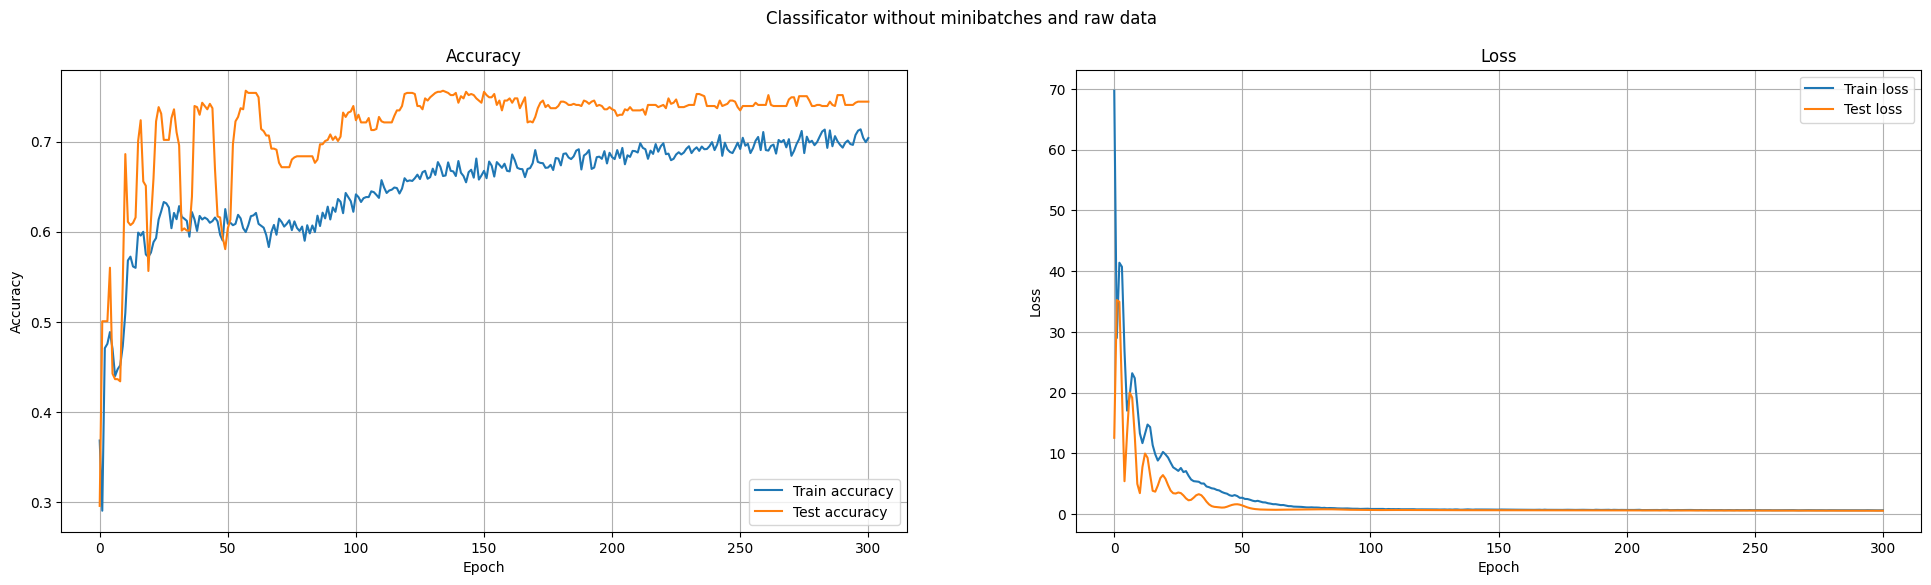

Train accuracy: 0.7038 | Test accuracy: 0.7442
Train loss: 0.6130 | Test loss: 0.5508


In [121]:
INPUT_SIZE = x_train.shape[1]
HIDDEN_SIZE = 256
OUTPUT_SIZE = 3
DROPOUT = 0.2
LR = 0.001
EPOCHS = 301

run_experiment(
    title="Classificator without minibatches and raw data",
    model_class=HousePriceClassificator,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    use_minibatch=False,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

#### OHE : Scaled data without microbatches


--- Running: Classificator without minibatches and scaled data ---
Epoch: 0 | Train loss: 1.0711 | Train acc: 0.5083 | Test loss: 1.0149 | Test acc: 0.6461
Epoch: 20 | Train loss: 0.5820 | Train acc: 0.7599 | Test loss: 0.5725 | Test acc: 0.7358
Epoch: 40 | Train loss: 0.4945 | Train acc: 0.7714 | Test loss: 0.4851 | Test acc: 0.7709
Epoch: 60 | Train loss: 0.4637 | Train acc: 0.7760 | Test loss: 0.4501 | Test acc: 0.7745
Epoch: 80 | Train loss: 0.4368 | Train acc: 0.7796 | Test loss: 0.4368 | Test acc: 0.7758
Epoch: 100 | Train loss: 0.4307 | Train acc: 0.7775 | Test loss: 0.4281 | Test acc: 0.7782
Epoch: 120 | Train loss: 0.4143 | Train acc: 0.7972 | Test loss: 0.4249 | Test acc: 0.7842
Epoch: 140 | Train loss: 0.4092 | Train acc: 0.7854 | Test loss: 0.4230 | Test acc: 0.7842
Epoch: 160 | Train loss: 0.4098 | Train acc: 0.7863 | Test loss: 0.4224 | Test acc: 0.7879
Epoch: 180 | Train loss: 0.4033 | Train acc: 0.7921 | Test loss: 0.4233 | Test acc: 0.7867
Epoch: 200 | Train loss: 0.4

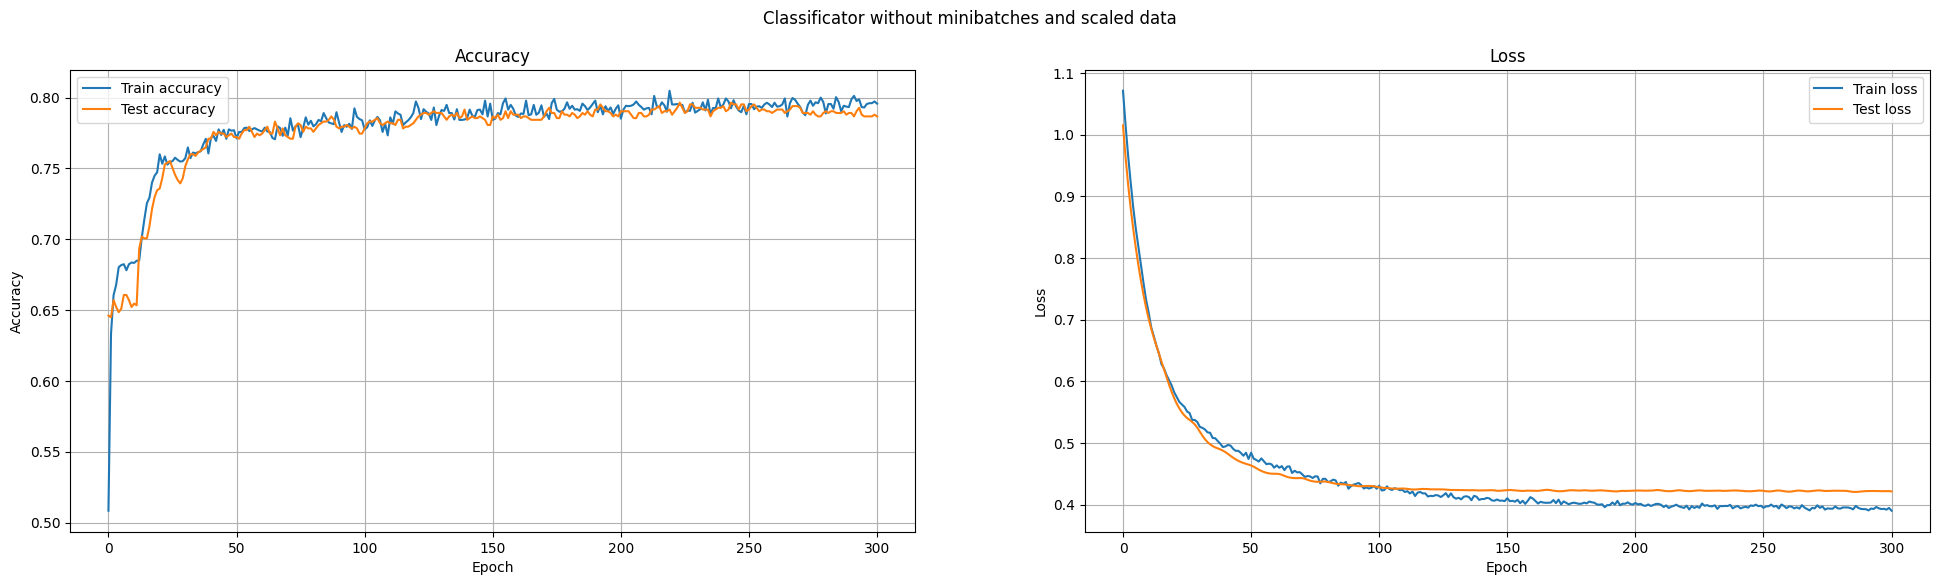

Train accuracy: 0.7957 | Test accuracy: 0.7867
Train loss: 0.3902 | Test loss: 0.4215


In [122]:
run_experiment(
    title="Classificator without minibatches and scaled data",
    model_class=HousePriceClassificator,
    x_test=x_test_scaled,
    y_test=y_test,
    x_train=x_train_scaled,
    y_train=y_train,
    use_minibatch=False,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

#### OHE : Raw data with microbatches


--- Running: Classificator with minibatches and raw data ---
Epoch: 0 | Train loss: 0.6735 | Train acc: 0.7166 | Test loss: 0.5318 | Test acc: 0.7394
Epoch: 20 | Train loss: 0.4093 | Train acc: 0.7827 | Test loss: 0.4240 | Test acc: 0.7758
Epoch: 40 | Train loss: 0.4013 | Train acc: 0.7896 | Test loss: 0.4217 | Test acc: 0.7964
Epoch: 60 | Train loss: 0.3963 | Train acc: 0.7890 | Test loss: 0.4270 | Test acc: 0.7794
Epoch: 80 | Train loss: 0.3920 | Train acc: 0.7945 | Test loss: 0.4296 | Test acc: 0.7733
Epoch: 100 | Train loss: 0.3928 | Train acc: 0.7905 | Test loss: 0.4247 | Test acc: 0.7939
Epoch: 120 | Train loss: 0.3894 | Train acc: 0.7966 | Test loss: 0.4306 | Test acc: 0.7891
Epoch: 140 | Train loss: 0.3864 | Train acc: 0.7966 | Test loss: 0.4375 | Test acc: 0.7770
Epoch: 160 | Train loss: 0.3865 | Train acc: 0.7969 | Test loss: 0.4295 | Test acc: 0.7903
Epoch: 180 | Train loss: 0.3841 | Train acc: 0.7975 | Test loss: 0.4347 | Test acc: 0.7842
Epoch: 200 | Train loss: 0.3838 | 

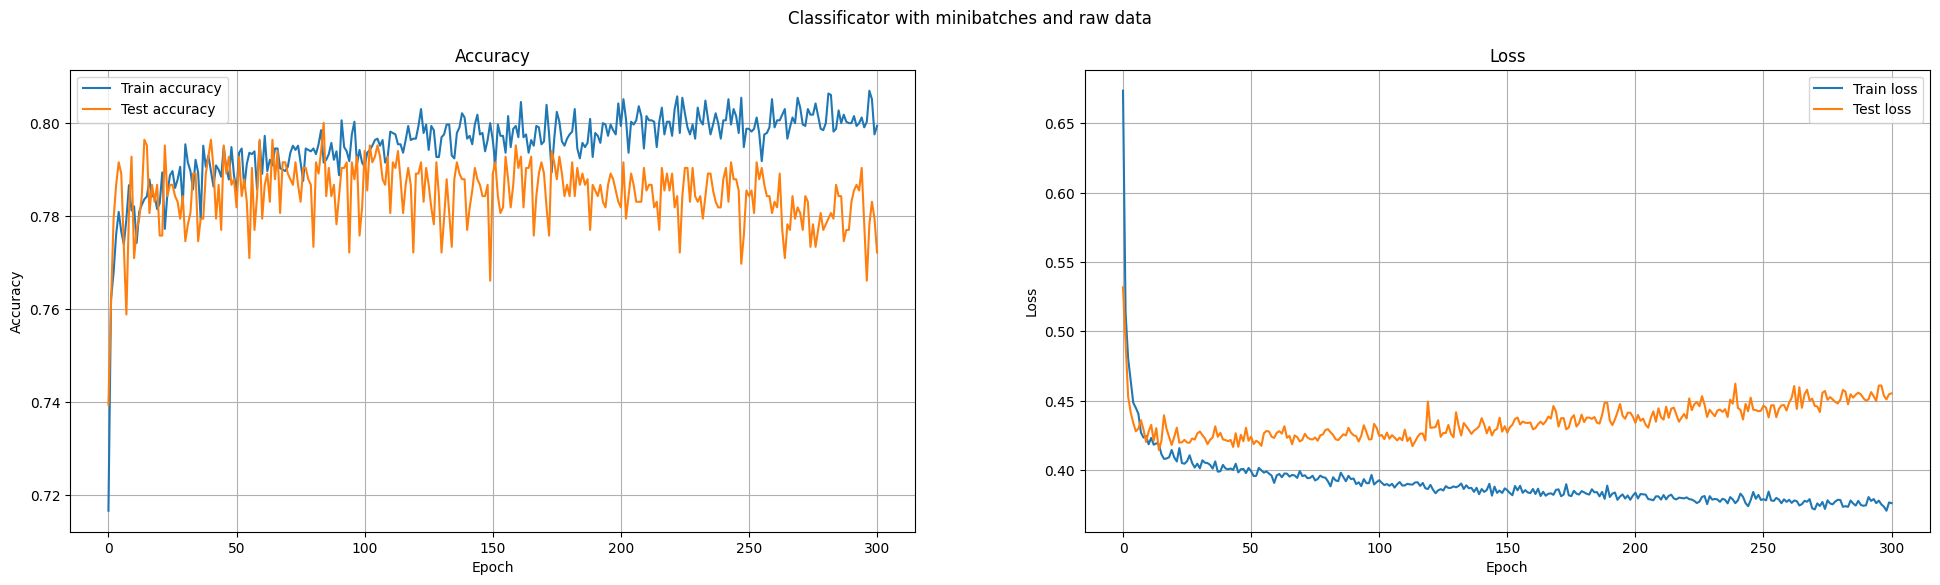

Train accuracy: 0.7993 | Test accuracy: 0.7721
Train loss: 0.3763 | Test loss: 0.4554


In [123]:
run_experiment(
    title="Classificator with minibatches and raw data",
    model_class=HousePriceClassificator,
    train_loader=train_loader,
    test_loader=test_loader,
    use_minibatch=True,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

#### OHE : Scaled data with microbatches


--- Running: Classificator with minibatches and scaled data ---
Epoch: 0 | Train loss: 0.6735 | Train acc: 0.7166 | Test loss: 0.5318 | Test acc: 0.7394
Epoch: 20 | Train loss: 0.4093 | Train acc: 0.7827 | Test loss: 0.4240 | Test acc: 0.7758
Epoch: 40 | Train loss: 0.4013 | Train acc: 0.7896 | Test loss: 0.4217 | Test acc: 0.7964
Epoch: 60 | Train loss: 0.3963 | Train acc: 0.7890 | Test loss: 0.4270 | Test acc: 0.7794
Epoch: 80 | Train loss: 0.3920 | Train acc: 0.7945 | Test loss: 0.4296 | Test acc: 0.7733
Epoch: 100 | Train loss: 0.3928 | Train acc: 0.7905 | Test loss: 0.4247 | Test acc: 0.7939
Epoch: 120 | Train loss: 0.3894 | Train acc: 0.7966 | Test loss: 0.4306 | Test acc: 0.7891
Epoch: 140 | Train loss: 0.3864 | Train acc: 0.7966 | Test loss: 0.4375 | Test acc: 0.7770
Epoch: 160 | Train loss: 0.3865 | Train acc: 0.7969 | Test loss: 0.4295 | Test acc: 0.7903
Epoch: 180 | Train loss: 0.3841 | Train acc: 0.7975 | Test loss: 0.4347 | Test acc: 0.7842
Epoch: 200 | Train loss: 0.3838

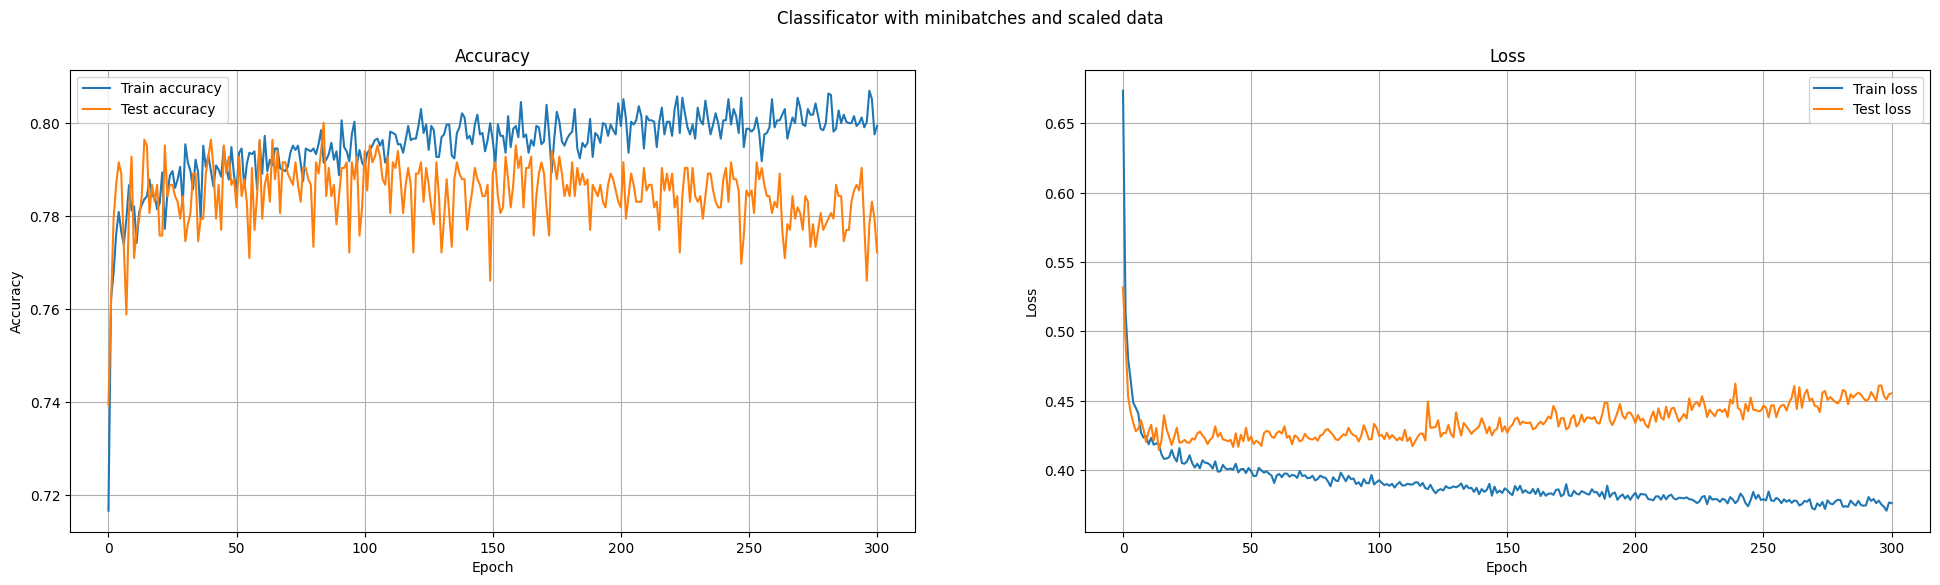

Train accuracy: 0.7993 | Test accuracy: 0.7721
Train loss: 0.3763 | Test loss: 0.4554


In [124]:
run_experiment(
    title="Classificator with minibatches and scaled data",
    model_class=HousePriceClassificator,
    train_loader=train_loader_scaled,
    test_loader=test_loader_scaled,
    use_minibatch=True,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

### 2.1.1 BatchNorm Layer

In [125]:
class HousePriceClassificatorBatchNormLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.bn2 = nn.BatchNorm1d(self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#### OHNE : raw data


--- Running: Classificator with minibatches, batch normalization and raw data ---
Epoch: 0 | Train loss: 1.1156 | Train acc: 0.3631 | Test loss: 3.7614 | Test acc: 0.3503
Epoch: 20 | Train loss: 0.5699 | Train acc: 0.7260 | Test loss: 0.8256 | Test acc: 0.6024
Epoch: 40 | Train loss: 0.5178 | Train acc: 0.7493 | Test loss: 0.8469 | Test acc: 0.5273
Epoch: 60 | Train loss: 0.4783 | Train acc: 0.7702 | Test loss: 1.2470 | Test acc: 0.4776
Epoch: 80 | Train loss: 0.4695 | Train acc: 0.7675 | Test loss: 1.3368 | Test acc: 0.5103
Epoch: 100 | Train loss: 0.4577 | Train acc: 0.7620 | Test loss: 1.1877 | Test acc: 0.5273
Epoch: 120 | Train loss: 0.4470 | Train acc: 0.7730 | Test loss: 1.4777 | Test acc: 0.4606
Epoch: 140 | Train loss: 0.4375 | Train acc: 0.7772 | Test loss: 1.6759 | Test acc: 0.4315
Epoch: 160 | Train loss: 0.4313 | Train acc: 0.7769 | Test loss: 1.9593 | Test acc: 0.4097
Epoch: 180 | Train loss: 0.4289 | Train acc: 0.7757 | Test loss: 1.6164 | Test acc: 0.4667
Epoch: 200 | 

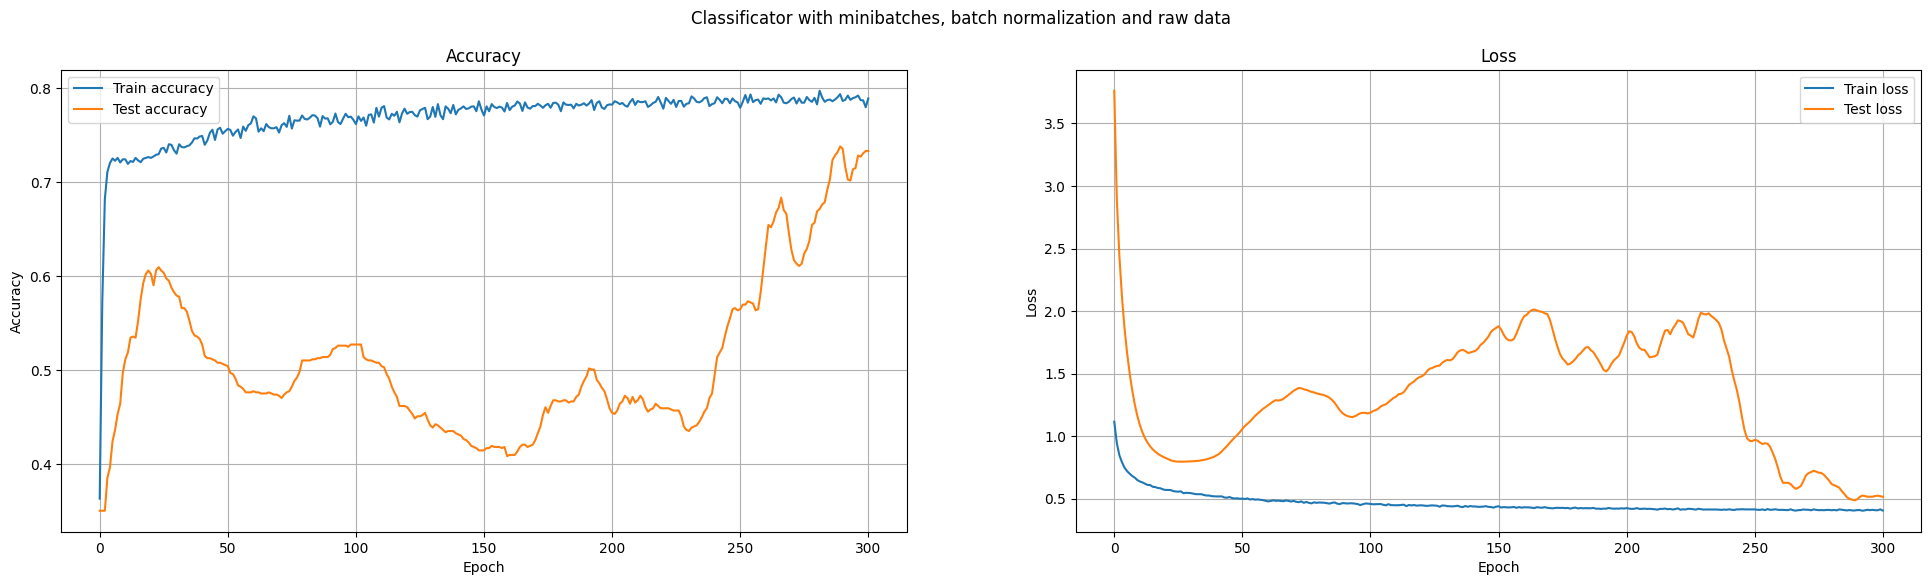

Train accuracy: 0.7893 | Test accuracy: 0.7333
Train loss: 0.4050 | Test loss: 0.5152


In [126]:
run_experiment(
    title="Classificator with minibatches, batch normalization and raw data",
    model_class=HousePriceClassificatorBatchNormLayer,
    x_test=x_test,
    y_test=y_test,
    x_train=x_train,
    y_train=y_train,
    use_minibatch=False,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

#### OHE : Scaled data without minibatches


--- Running: Classificator with minibatches, batch normalization and scaled data ---
Epoch: 0 | Train loss: 1.1178 | Train acc: 0.3783 | Test loss: 1.0326 | Test acc: 0.6109
Epoch: 20 | Train loss: 0.5303 | Train acc: 0.7663 | Test loss: 0.5491 | Test acc: 0.7588
Epoch: 40 | Train loss: 0.4734 | Train acc: 0.7784 | Test loss: 0.4665 | Test acc: 0.7770
Epoch: 60 | Train loss: 0.4454 | Train acc: 0.7854 | Test loss: 0.4395 | Test acc: 0.7879
Epoch: 80 | Train loss: 0.4255 | Train acc: 0.7857 | Test loss: 0.4296 | Test acc: 0.7867
Epoch: 100 | Train loss: 0.4217 | Train acc: 0.7869 | Test loss: 0.4261 | Test acc: 0.7879
Epoch: 120 | Train loss: 0.4115 | Train acc: 0.7981 | Test loss: 0.4253 | Test acc: 0.7903
Epoch: 140 | Train loss: 0.4074 | Train acc: 0.7908 | Test loss: 0.4236 | Test acc: 0.7927
Epoch: 160 | Train loss: 0.4070 | Train acc: 0.7884 | Test loss: 0.4231 | Test acc: 0.7915
Epoch: 180 | Train loss: 0.4031 | Train acc: 0.7884 | Test loss: 0.4233 | Test acc: 0.7927
Epoch: 200

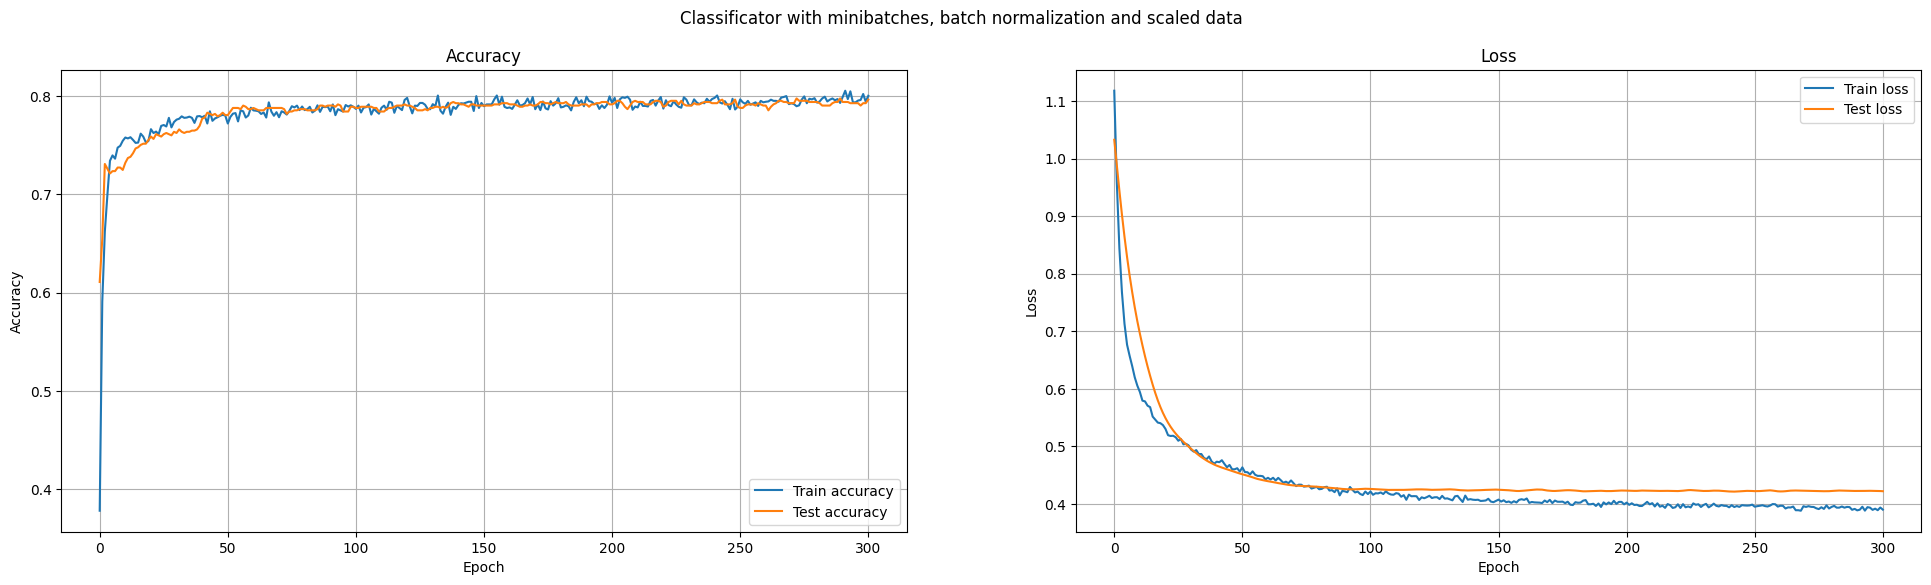

Train accuracy: 0.8002 | Test accuracy: 0.7964
Train loss: 0.3902 | Test loss: 0.4221


In [127]:
run_experiment(
    title="Classificator with minibatches, batch normalization and scaled data",
    model_class=HousePriceClassificatorBatchNormLayer,
    x_test=x_test_scaled,
    y_test=y_test,
    x_train=x_train_scaled,
    y_train=y_train,
    use_minibatch=False,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

#### OHE : Raw data and minicatches


--- Running: Classificator with minibatches, batch normalization and raw data ---
Epoch: 0 | Train loss: 0.6300 | Train acc: 0.7257 | Test loss: 0.5175 | Test acc: 0.7467
Epoch: 20 | Train loss: 0.4310 | Train acc: 0.7772 | Test loss: 0.4215 | Test acc: 0.7782
Epoch: 40 | Train loss: 0.4176 | Train acc: 0.7836 | Test loss: 0.4137 | Test acc: 0.8000
Epoch: 60 | Train loss: 0.4040 | Train acc: 0.7930 | Test loss: 0.4218 | Test acc: 0.7927
Epoch: 80 | Train loss: 0.3987 | Train acc: 0.7969 | Test loss: 0.4272 | Test acc: 0.7685
Epoch: 100 | Train loss: 0.4089 | Train acc: 0.7830 | Test loss: 0.4213 | Test acc: 0.7976
Epoch: 120 | Train loss: 0.3928 | Train acc: 0.7999 | Test loss: 0.4228 | Test acc: 0.7855
Epoch: 140 | Train loss: 0.3938 | Train acc: 0.7915 | Test loss: 0.4258 | Test acc: 0.7842
Epoch: 160 | Train loss: 0.3942 | Train acc: 0.7933 | Test loss: 0.4183 | Test acc: 0.7903
Epoch: 180 | Train loss: 0.3939 | Train acc: 0.7957 | Test loss: 0.4270 | Test acc: 0.7939
Epoch: 200 | 

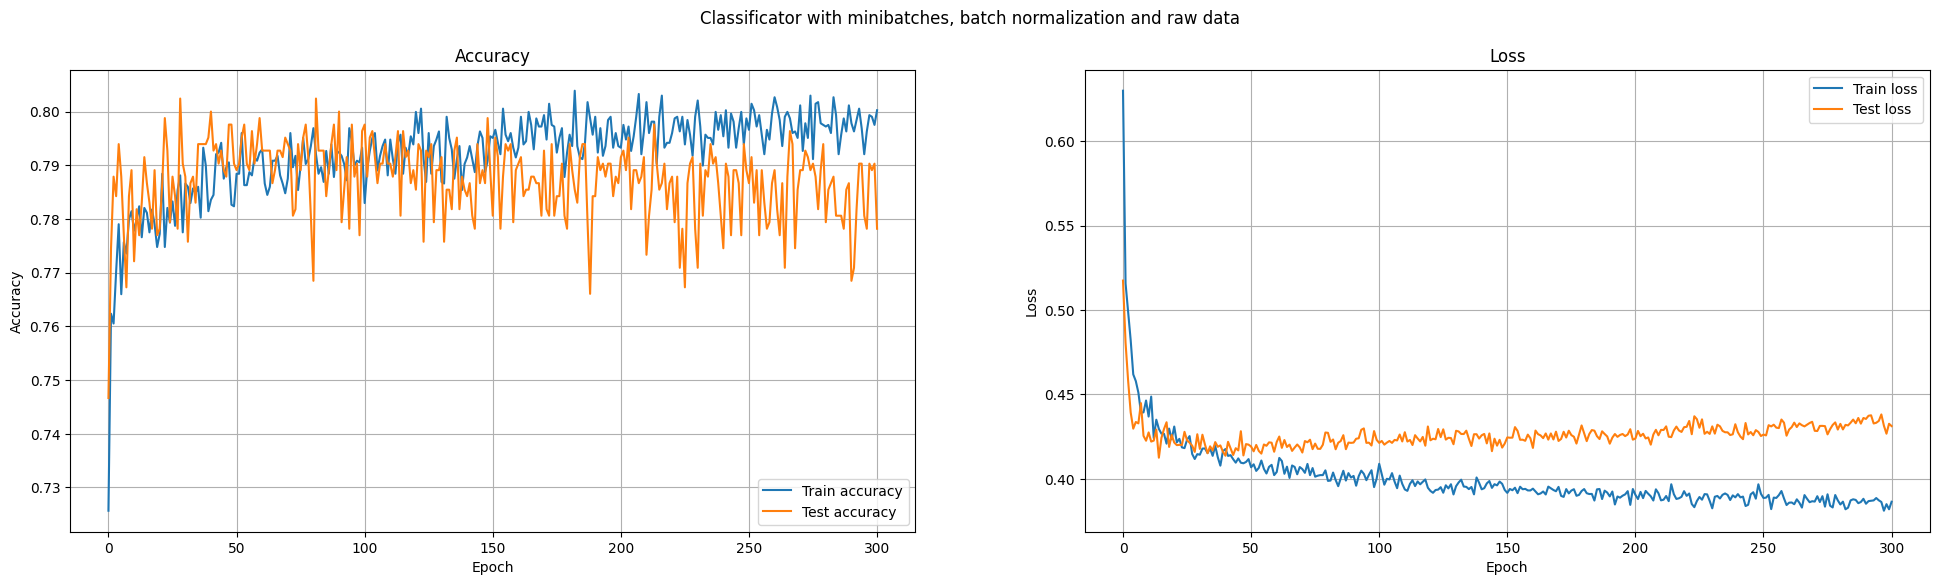

Train accuracy: 0.8002 | Test accuracy: 0.7782
Train loss: 0.3864 | Test loss: 0.4312


In [128]:
run_experiment(
    title="Classificator with minibatches, batch normalization and raw data",
    model_class=HousePriceClassificatorBatchNormLayer,
    train_loader=train_loader,
    test_loader=test_loader,
    use_minibatch=True,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS
)

#### OHE : Scaled data and minibatches


--- Running: Classificator with minibatches, batch normalization and scaled data ---
Epoch: 0 | Train loss: 0.6300 | Train acc: 0.7257 | Test loss: 0.5175 | Test acc: 0.7467
Epoch: 20 | Train loss: 0.4310 | Train acc: 0.7772 | Test loss: 0.4215 | Test acc: 0.7782
Epoch: 40 | Train loss: 0.4176 | Train acc: 0.7836 | Test loss: 0.4137 | Test acc: 0.8000
Epoch: 60 | Train loss: 0.4040 | Train acc: 0.7930 | Test loss: 0.4218 | Test acc: 0.7927
Epoch: 80 | Train loss: 0.3987 | Train acc: 0.7969 | Test loss: 0.4272 | Test acc: 0.7685
Epoch: 100 | Train loss: 0.4089 | Train acc: 0.7830 | Test loss: 0.4213 | Test acc: 0.7976
Epoch: 120 | Train loss: 0.3928 | Train acc: 0.7999 | Test loss: 0.4228 | Test acc: 0.7855
Epoch: 140 | Train loss: 0.3938 | Train acc: 0.7915 | Test loss: 0.4258 | Test acc: 0.7842
Epoch: 160 | Train loss: 0.3942 | Train acc: 0.7933 | Test loss: 0.4183 | Test acc: 0.7903
Epoch: 180 | Train loss: 0.3939 | Train acc: 0.7957 | Test loss: 0.4270 | Test acc: 0.7939
Epoch: 200

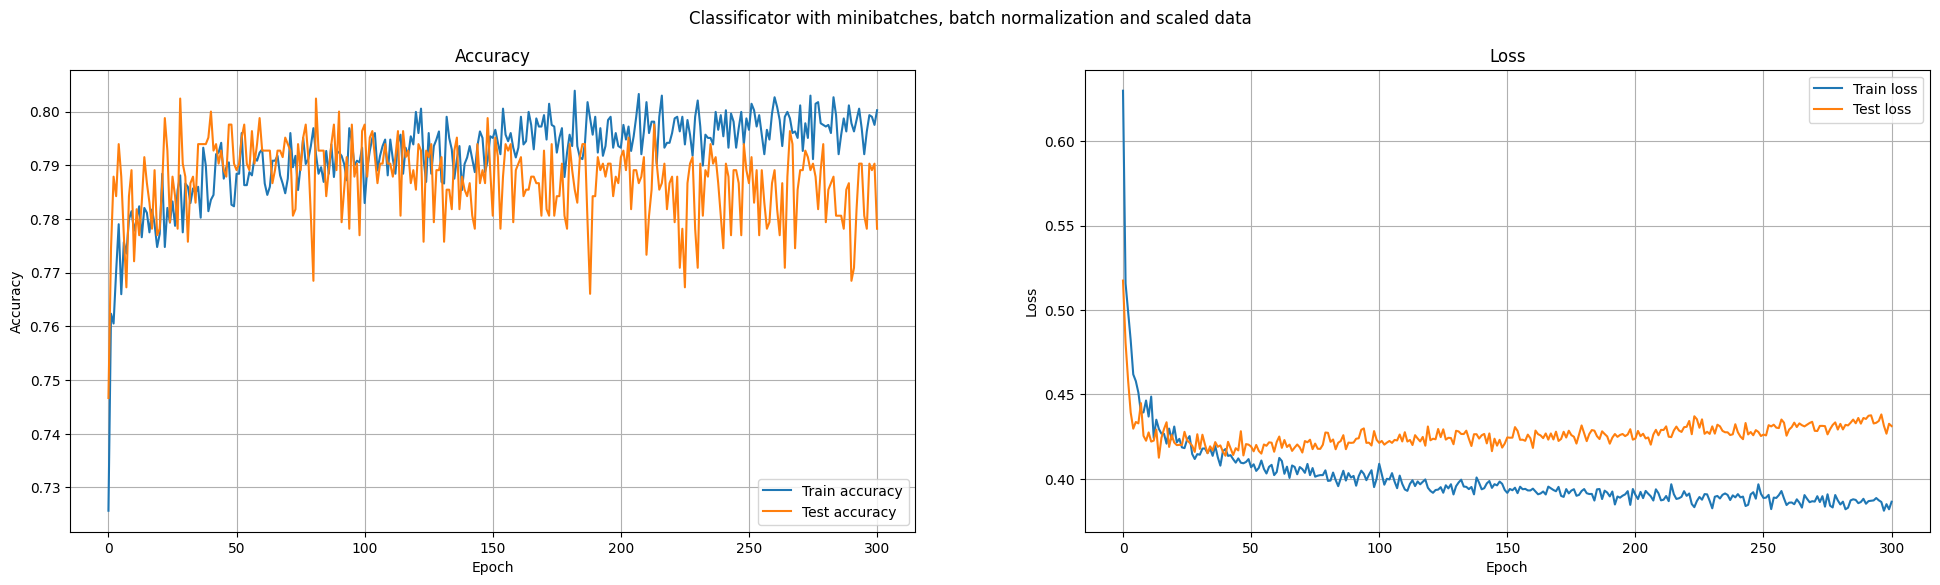

Train accuracy: 0.8002 | Test accuracy: 0.7782
Train loss: 0.3864 | Test loss: 0.4312


In [129]:
run_experiment(
    title="Classificator with minibatches, batch normalization and scaled data",
    model_class=HousePriceClassificatorBatchNormLayer,
    train_loader=train_loader_scaled,
    test_loader=test_loader_scaled,
    use_minibatch=True,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=301
)

#### Wnioski
- Skalowanie danych polepsza wyniki modelu, dlatego warto jest je stosować
- Korzystanie z BatchLayer nie wprowadza znaczących popaw modelu, aczkolwiek obecny najwyższy wynik 79.64 uzyskałem korzystając z tej opcji
- Zarówno modele korzystające z minipakietow jak i niekorzystające z nich osiągają podobne wartości. Żeby móc lepiej określić, które sprawdzą się lepiej trzeba przeprowadzić więcej eksperymentów i dostorić hiperparametry
- Bez dostrajania można stwierdzić, że korzystając z minibatchy nasze modele się lekko przeuczają -> widać wzrost straty na testowym mimo spadku na treningowym
- Może być warte przetestowanie regularyzacji

### 2.1.2 Testowanie różnych wartości dla OHE oraz skalowanych danych bez BatchLayer

In [138]:
from itertools import product

def run_grid_search(
    x_train, y_train, x_test, y_test,
    input_size,
    use_minibatch=True,
    train_loader=None,
    test_loader=None,
    epochs=501,
    output_size=3,
    model_class=HousePriceClassificator,
    is_plot=False
):
    # grid search parameters
    BATCH_SIZES = [32, 64, 128, 256]
    HIDDEN_SIZES = [64, 128, 256, 512, 1024]
    DROPOUTS = [0.1, 0.2, 0.3, 0.4, 0.5]
    LRS = [0.0001, 0.0002, 0.0005, 0.001, 0.002]

    results = []

    for hidden_size, dropout, lr, batch_size in product(HIDDEN_SIZES, DROPOUTS, LRS, BATCH_SIZES):
        title = f"H{hidden_size}_DO{dropout}_LR{lr}_BS{batch_size}"

        # prepare data if using minibatches
        if use_minibatch:
            train_loader_current, test_loader_current = prepare_data_into_minibatches(
                x_train, y_train, x_test, y_test, batch_size
            )
        else:
            train_loader_current, test_loader_current = None, None

        # orun experiments
        train_accuracy, test_accuracy, train_loss, test_loss = run_experiment(
            title=title,
            model_class=model_class,
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            train_loader=train_loader_current,
            test_loader=test_loader_current,
            use_minibatch=use_minibatch,
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            dropout=dropout,
            lr=lr,
            epochs=epochs,
            verbose=False,
            is_plot=is_plot
        )

        # create a dict with results
        results.append({
            'hidden_size': hidden_size,
            'dropout': dropout,
            'lr': lr,
            'batch_size': batch_size,
            'train_accuracy': train_accuracy[-1],
            'test_accuracy': test_accuracy[-1],
            'train_loss': train_loss[-1],
            'test_loss': test_loss[-1]
        })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by='test_accuracy', ascending=False, inplace=True).reset_index(drop=True)

    return results_df


In [ ]:
# # without minibatches
# results_df = run_grid_search(
#     x_train, y_train, x_test, y_test,
#     input_size=INPUT_SIZE,
#     use_minibatch=False,
#     epochs=301,
#     output_size=OUTPUT_SIZE,
#     model_class=HousePriceClassificator,
#     is_plot=False
# )

# # with minibatches
# results_df_minibatches = run_grid_search(
#     x_train_scaled, y_train, x_test_scaled, y_test,
#     input_size=INPUT_SIZE,
#     use_minibatch=True,
#     epochs=301,
#     output_size=OUTPUT_SIZE,
#     model_class=HousePriceClassificator,
#     is_plot=False
# )

# print("Results without minibatches")
# display(results_df.head(10))

# print("Results with minibatches")
# display(results_df_minibatches.head(10))



--- Running: H64_DO0.1_LR0.0001_BS32 ---
Train accuracy: 0.5920 | Test accuracy: 0.7358
Train loss: 3.9319 | Test loss: 1.0965

--- Running: H64_DO0.1_LR0.0001_BS64 ---
Train accuracy: 0.5920 | Test accuracy: 0.7358
Train loss: 3.9319 | Test loss: 1.0965

--- Running: H64_DO0.1_LR0.0001_BS128 ---
Train accuracy: 0.5920 | Test accuracy: 0.7358
Train loss: 3.9319 | Test loss: 1.0965

--- Running: H64_DO0.1_LR0.0001_BS256 ---
Train accuracy: 0.5920 | Test accuracy: 0.7358
Train loss: 3.9319 | Test loss: 1.0965

--- Running: H64_DO0.1_LR0.0002_BS32 ---
Train accuracy: 0.6105 | Test accuracy: 0.7442
Train loss: 1.5888 | Test loss: 0.6424

--- Running: H64_DO0.1_LR0.0002_BS64 ---
Train accuracy: 0.6105 | Test accuracy: 0.7442
Train loss: 1.5888 | Test loss: 0.6424

--- Running: H64_DO0.1_LR0.0002_BS128 ---
Train accuracy: 0.6105 | Test accuracy: 0.7442
Train loss: 1.5888 | Test loss: 0.6424

--- Running: H64_DO0.1_LR0.0002_BS256 ---
Train accuracy: 0.6105 | Test accuracy: 0.7442
Train loss:

AttributeError: 'NoneType' object has no attribute 'reset_index'

### 2.1.3 Dodanie Regularyzacji

- Regularyzacja L2 jest automatycznie wspierana poprzed dodanie weight_decay w optymalizatorze Adam
- Regularyzacje L1 trzeba napisać ręcznie

#### OHE : L2 i prosty model HousePriceClassificator - scaled data


--- Running: Classificator without minibatches and raw data ---
Epoch: 0 | Train loss: 1.0711 | Train acc: 0.5083 | Test loss: 1.0159 | Test acc: 0.6461
Epoch: 20 | Train loss: 0.5875 | Train acc: 0.7590 | Test loss: 0.5794 | Test acc: 0.7394
Epoch: 40 | Train loss: 0.5006 | Train acc: 0.7678 | Test loss: 0.4930 | Test acc: 0.7697
Epoch: 60 | Train loss: 0.4720 | Train acc: 0.7730 | Test loss: 0.4610 | Test acc: 0.7758
Epoch: 80 | Train loss: 0.4482 | Train acc: 0.7827 | Test loss: 0.4478 | Test acc: 0.7721
Epoch: 100 | Train loss: 0.4407 | Train acc: 0.7784 | Test loss: 0.4385 | Test acc: 0.7745
Epoch: 120 | Train loss: 0.4291 | Train acc: 0.7875 | Test loss: 0.4331 | Test acc: 0.7830
Epoch: 140 | Train loss: 0.4233 | Train acc: 0.7902 | Test loss: 0.4301 | Test acc: 0.7806
Epoch: 160 | Train loss: 0.4238 | Train acc: 0.7857 | Test loss: 0.4282 | Test acc: 0.7830
Epoch: 180 | Train loss: 0.4230 | Train acc: 0.7881 | Test loss: 0.4274 | Test acc: 0.7794
Epoch: 200 | Train loss: 0.4187

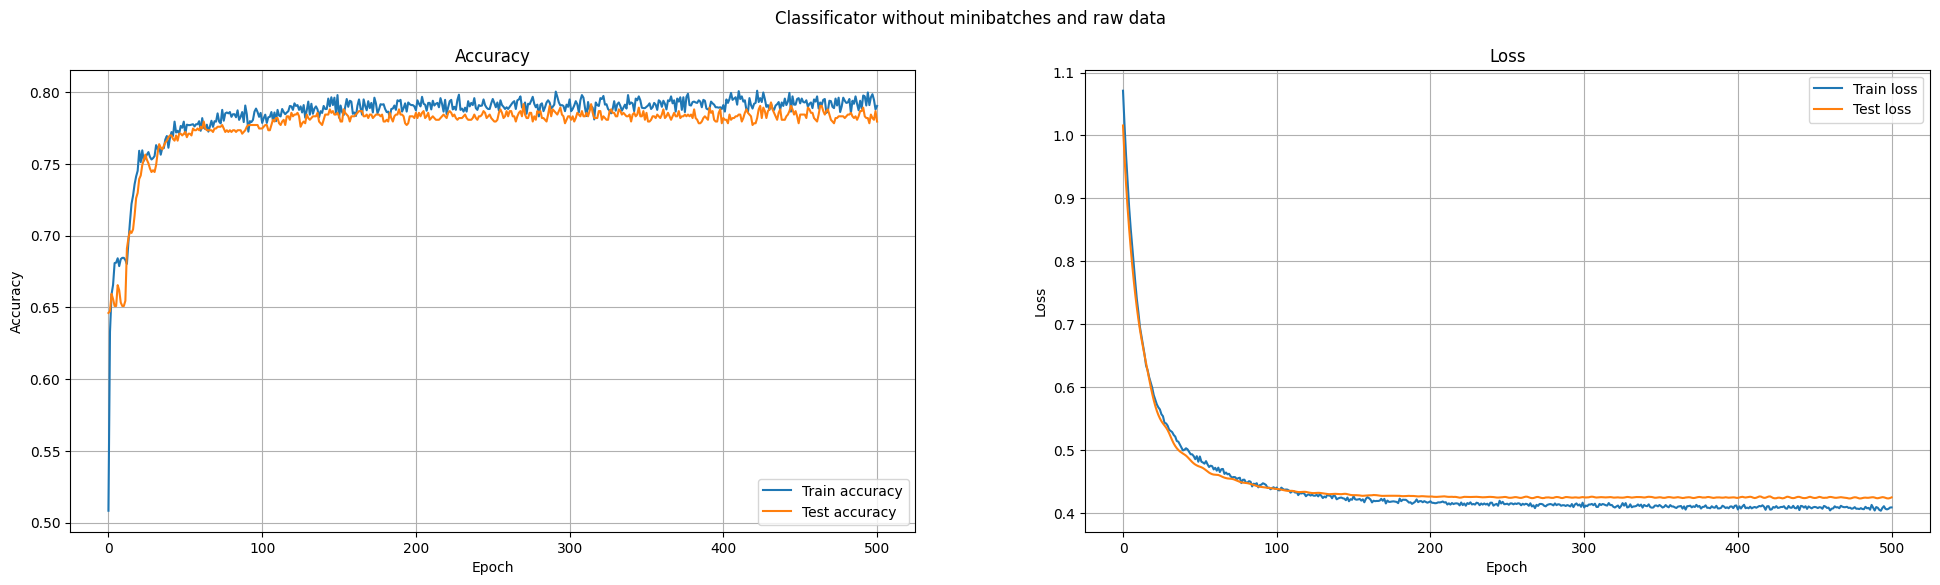

Train accuracy: 0.7902 | Test accuracy: 0.7794
Train loss: 0.4090 | Test loss: 0.4250


([tensor(0.5083),
  tensor(0.6329),
  tensor(0.6590),
  tensor(0.6657),
  tensor(0.6808),
  tensor(0.6811),
  tensor(0.6841),
  tensor(0.6787),
  tensor(0.6835),
  tensor(0.6844),
  tensor(0.6844),
  tensor(0.6829),
  tensor(0.6802),
  tensor(0.6957),
  tensor(0.7096),
  tensor(0.7220),
  tensor(0.7278),
  tensor(0.7357),
  tensor(0.7411),
  tensor(0.7451),
  tensor(0.7590),
  tensor(0.7511),
  tensor(0.7593),
  tensor(0.7520),
  tensor(0.7542),
  tensor(0.7563),
  tensor(0.7581),
  tensor(0.7548),
  tensor(0.7530),
  tensor(0.7539),
  tensor(0.7554),
  tensor(0.7630),
  tensor(0.7602),
  tensor(0.7624),
  tensor(0.7563),
  tensor(0.7608),
  tensor(0.7608),
  tensor(0.7669),
  tensor(0.7693),
  tensor(0.7611),
  tensor(0.7678),
  tensor(0.7721),
  tensor(0.7693),
  tensor(0.7793),
  tensor(0.7717),
  tensor(0.7730),
  tensor(0.7708),
  tensor(0.7763),
  tensor(0.7751),
  tensor(0.7793),
  tensor(0.7705),
  tensor(0.7772),
  tensor(0.7769),
  tensor(0.7769),
  tensor(0.7772),
  tensor(0

In [ ]:
_, _, _, _ = run_experiment(
    title="Classificator without minibatches and raw data",
    model_class=HousePriceClassificator,
    x_train=x_train_scaled,
    y_train=y_train,
    x_test=x_test_scaled,
    y_test=y_test,
    use_minibatch=False,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=501,
    weight_decay=0.005,
    verbose=True,
    is_plot=True
)

#### OHE : L2 i prosty model HousePriceClassifcator - scaled data and minibatches


--- Running: Classificator without minibatches and raw data ---
Epoch: 0 | Train loss: 0.6781 | Train acc: 0.7160 | Test loss: 0.5370 | Test acc: 0.7418
Epoch: 20 | Train loss: 0.4345 | Train acc: 0.7763 | Test loss: 0.4329 | Test acc: 0.7673
Epoch: 40 | Train loss: 0.4277 | Train acc: 0.7824 | Test loss: 0.4316 | Test acc: 0.7745
Epoch: 60 | Train loss: 0.4227 | Train acc: 0.7839 | Test loss: 0.4293 | Test acc: 0.7782
Epoch: 80 | Train loss: 0.4260 | Train acc: 0.7821 | Test loss: 0.4339 | Test acc: 0.7830
Epoch: 100 | Train loss: 0.4249 | Train acc: 0.7830 | Test loss: 0.4317 | Test acc: 0.7794
Epoch: 120 | Train loss: 0.4253 | Train acc: 0.7857 | Test loss: 0.4277 | Test acc: 0.7891
Epoch: 140 | Train loss: 0.4216 | Train acc: 0.7915 | Test loss: 0.4264 | Test acc: 0.7782
Epoch: 160 | Train loss: 0.4248 | Train acc: 0.7887 | Test loss: 0.4381 | Test acc: 0.7830
Epoch: 180 | Train loss: 0.4232 | Train acc: 0.7836 | Test loss: 0.4292 | Test acc: 0.7976
Epoch: 200 | Train loss: 0.4254

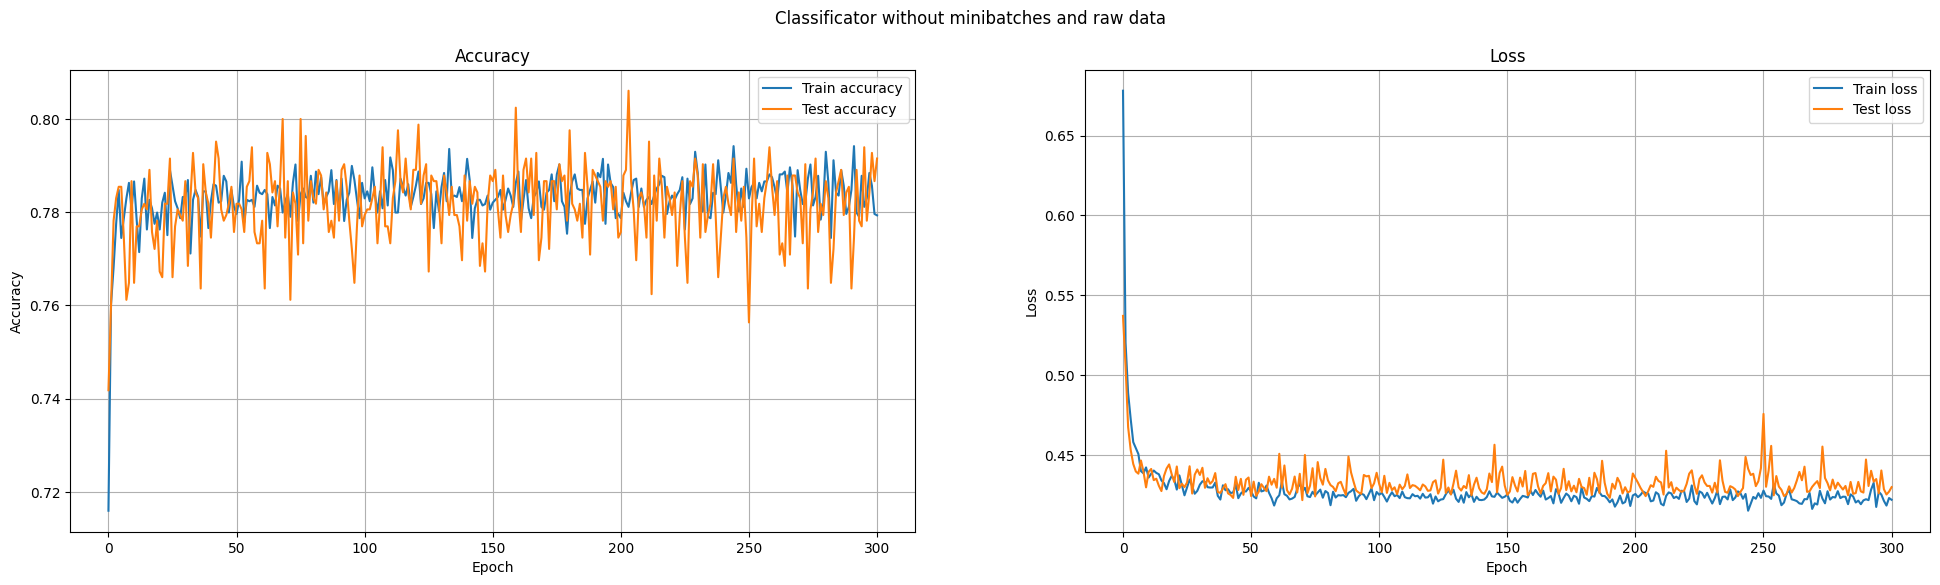

Train accuracy: 0.7793 | Test accuracy: 0.7915
Train loss: 0.4218 | Test loss: 0.4297


In [146]:
_, _, _, _ = run_experiment(
    title="Classificator without minibatches and raw data",
    model_class=HousePriceClassificator,
   train_loader=train_loader_scaled,
    test_loader=test_loader_scaled,
    use_minibatch=True,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=EPOCHS,
    weight_decay=0.005,
    verbose=True,
    is_plot=True
)

#### OHE : L2 i prosty model HousePriceClassifcatorBatchLayer - scaled data without minibatches


--- Running: Classificator without minibatches and scaled data ---
Epoch: 0 | Train loss: 1.1178 | Train acc: 0.3783 | Test loss: 1.0329 | Test acc: 0.6109
Epoch: 20 | Train loss: 0.5320 | Train acc: 0.7645 | Test loss: 0.5617 | Test acc: 0.7600
Epoch: 40 | Train loss: 0.4741 | Train acc: 0.7802 | Test loss: 0.4749 | Test acc: 0.7697
Epoch: 60 | Train loss: 0.4446 | Train acc: 0.7848 | Test loss: 0.4463 | Test acc: 0.7842
Epoch: 80 | Train loss: 0.4247 | Train acc: 0.7921 | Test loss: 0.4358 | Test acc: 0.7927
Epoch: 100 | Train loss: 0.4204 | Train acc: 0.7872 | Test loss: 0.4306 | Test acc: 0.7939
Epoch: 120 | Train loss: 0.4096 | Train acc: 0.7993 | Test loss: 0.4296 | Test acc: 0.7915
Epoch: 140 | Train loss: 0.4072 | Train acc: 0.7954 | Test loss: 0.4273 | Test acc: 0.7952
Epoch: 160 | Train loss: 0.4059 | Train acc: 0.7924 | Test loss: 0.4269 | Test acc: 0.8000
Epoch: 180 | Train loss: 0.4010 | Train acc: 0.7936 | Test loss: 0.4273 | Test acc: 0.7879
Epoch: 200 | Train loss: 0.4

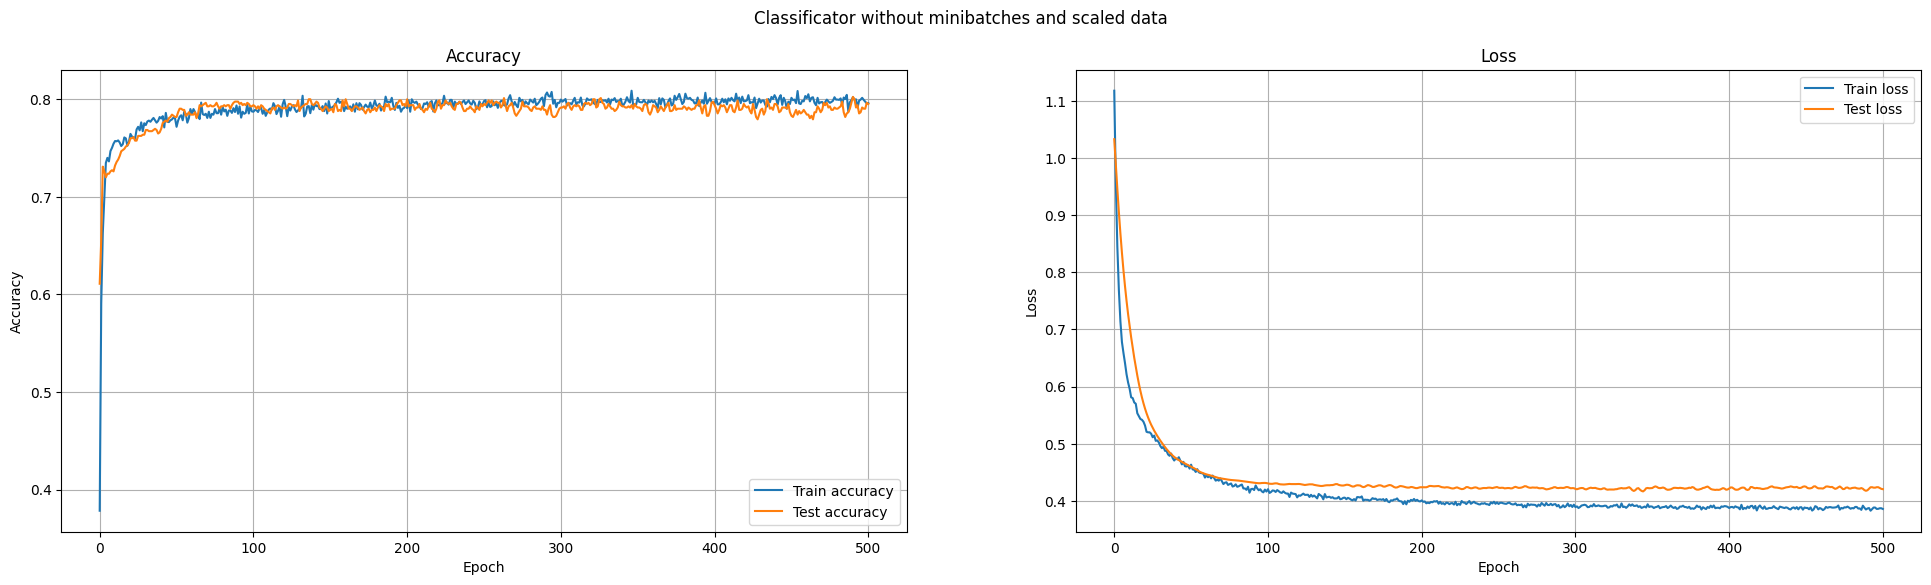

Train accuracy: 0.7960 | Test accuracy: 0.7952
Train loss: 0.3858 | Test loss: 0.4205


In [147]:
_, _, _, _ = run_experiment(
    title="Classificator without minibatches and scaled data",
    model_class=HousePriceClassificatorBatchNormLayer,
    x_train=x_train_scaled,
    y_train=y_train,
    x_test=x_test_scaled,
    y_test=y_test,
    use_minibatch=False,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=501,
    weight_decay=0.005,
    verbose=True,
    is_plot=True
)

#### OHE : L2 i prosty model HousePriceClassifcatorBatchLayer - scaled data and minibatches


--- Running: Classificator without minibatches and scaled data ---
Epoch: 0 | Train loss: 0.6309 | Train acc: 0.7251 | Test loss: 0.5226 | Test acc: 0.7467
Epoch: 20 | Train loss: 0.4442 | Train acc: 0.7721 | Test loss: 0.4329 | Test acc: 0.7733
Epoch: 40 | Train loss: 0.4397 | Train acc: 0.7811 | Test loss: 0.4223 | Test acc: 0.7927
Epoch: 60 | Train loss: 0.4289 | Train acc: 0.7863 | Test loss: 0.4252 | Test acc: 0.7915
Epoch: 80 | Train loss: 0.4267 | Train acc: 0.7860 | Test loss: 0.4261 | Test acc: 0.7903
Epoch: 100 | Train loss: 0.4342 | Train acc: 0.7772 | Test loss: 0.4248 | Test acc: 0.8012
Epoch: 120 | Train loss: 0.4204 | Train acc: 0.7881 | Test loss: 0.4222 | Test acc: 0.7964
Epoch: 140 | Train loss: 0.4232 | Train acc: 0.7887 | Test loss: 0.4246 | Test acc: 0.7855
Epoch: 160 | Train loss: 0.4284 | Train acc: 0.7839 | Test loss: 0.4200 | Test acc: 0.7842
Epoch: 180 | Train loss: 0.4215 | Train acc: 0.7872 | Test loss: 0.4214 | Test acc: 0.7976
Epoch: 200 | Train loss: 0.4

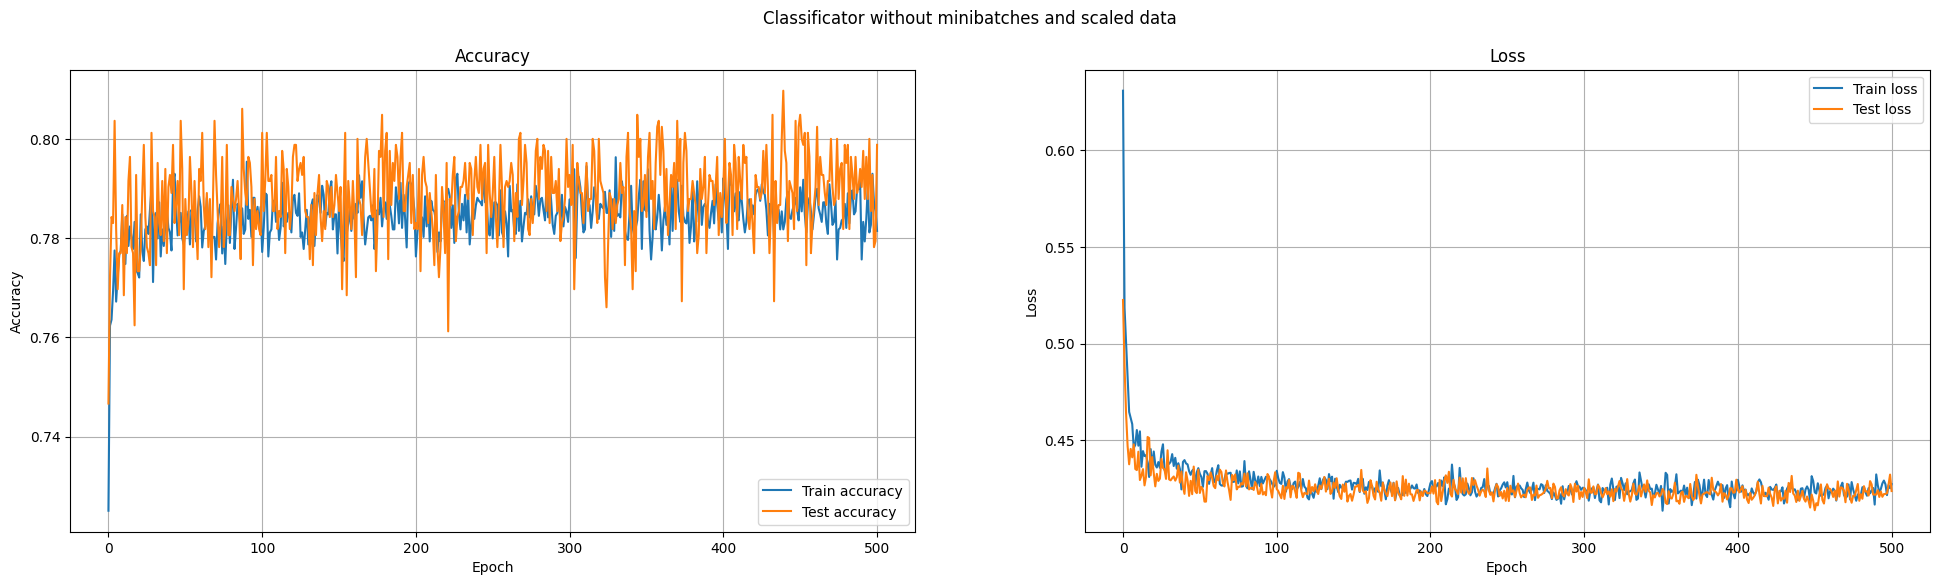

Train accuracy: 0.7814 | Test accuracy: 0.7988
Train loss: 0.4273 | Test loss: 0.4237


In [148]:
_, _, _, _ = run_experiment(
    title="Classificator without minibatches and scaled data",
    model_class=HousePriceClassificatorBatchNormLayer,
    train_loader=train_loader_scaled,
    test_loader=test_loader_scaled,
    use_minibatch=True,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT,
    lr=LR,
    epochs=501,
    weight_decay=0.005,
    verbose=True,
    is_plot=True
)